## Running the SUMMA setups
Here, we run SUMMA using pysumma, on the setupss we created in the previous notebook.
This is a computationally expensive notebook. 
If you don't have the computer power or time, you can run a less complex problem than the full problem, but the output (and graphs) in the next notebook will not be complete. 
If things start to fail, restart the server and run the simuluations in smaller loops before restarts. 

Complexity choices are, in order of increasing complexity: 
 - 1)   `default_prob = 1`: the "default" configuration with the "default" parameters. By "default" we mean whatever you chose in the summa setup files. 
 - 2a) `lhs_prob = 1`: the default configuration with exploration of the parameter space.
 - 2b) `config_prob = 1`: the default parameters with 8 different configurations (choices that have been seen to affect the model output in previous research) 
 - 3)   `lhs_config_prob = 1`: 8 different configurations with the default and the exploration of the parameter space.

The default problem will be run with every cmplexity choice.

Eight iterations of each loop are run for each problem, to cover a truth run and the 7 forcings each held to a daily constant in turn.
The time unit in the commnets given is written as "minoot", where 1 minoot= 1 minute on the CyberGIS for Water Xcede, but will be different on your computer or another computer. 
For comparision, one iteration of each problem (in order of increasing complexity) takes: 
 - 1)   8X ~0.3 minoots for 1 HRUs
 - 2a)  8X ~1.2 minoots for 1 HRU
 - 2b)  8X ~0.8 minoots for 1 HRU
 - 3)   8X ~73 minoots for 1 HRU
 
There are times in "minoots" for various cells in the notebook, so you can have an idea how long a cell might take to run. 
 
You can also make the problem run for fewer years to lower computational costs, changing `str(the_start)` and `str(the_end)`. You can test with as little as a day between `the_start` and `the_end`, but if you want to make the plots in this notebook and run the next notebook you will need >1 year (1 year is considered intialization period). 

<br>

### Make problem complexity choices here:
 
Note, you can choose all of these to be 1, but each step of complexity will contain the previous problem(s), so it is not necessary. It will result in more files, but if may be useful to check that each step of the problem expansion runs successfullly. If you have more than 10 HRUs (CAMELS subbasins in the example problem), it was decided that the problem is too big and you can only run the default problem (the complexity choice will get reset after the number of HRUs is determined). However, theoretically it will run with more HRUs. 

Another complexity choice you can make is to run a different length time-period. It is pre-populated to run 18 months, as the 6 years in the paper takes a long time without high-performance computing. 

Lastly, if you have any errors while running the pysumma problems, you can run a short time-period (1 day) in simpler pysumma mode by changing `debug` to 1 and rerunning. This will provide more detailed error messages. The problem WILL NOT run for the full time period if `debug = 1`.

In [1]:
default_prob = 0
lhs_prob = 0
config_prob = 0
lhs_config_prob = 1 #pre-populated this is 1 and the rest 0, to run full problem that is in the paper.

In [2]:
the_start = '1991-04-01 00:00' #pre-populated to '1991-04-01 00:00', but '1990-10-01 00:00' is in the paper.
the_end =   '1992-09-30 23:00' #pre-populated to '1992-09-30 23:00, but '1996-09-30 23:00' is in the paper.

In [3]:
# if 1, ONLY the one day problem with more detailed error messages will not run. 
# if 0, the problem will run from the_start to the_end as defined above.
debug = 0 #pre-populated to 0
the_end_debug = the_start[0:11] + '23:00'

<br>
Check that we loaded correct environment. This should show pysumma version 3.0.

In [4]:
conda list summa

# packages in environment at /opt/conda/envs/pysumma:
#
# Name                    Version                   Build  Channel
pysumma                   3.0.3                    pypi_0    pypi

Note: you may need to restart the kernel to use updated packages.


<br>
Load the imports.

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pysumma as ps
import xarray as xr
import pandas as pd
import gc
import os

<br>
Set up the paths and regionalize the paths in the configuration files that SUMMA will use.

In [6]:
top_folder = os.path.join(os.getcwd(), 'summa_camels')
settings_folder = os.path.join(top_folder, 'settings')
ps_working = os.path.join(top_folder, '.pysumma')

In [7]:
! cd {top_folder}; chmod +x installTestCases_local.sh; ./installTestCases_local.sh

In [8]:
# get number of HRUs
attrib = xr.open_dataset(settings_folder+'/attributes.nc')
the_hru = np.array(attrib['hruId'])
# change complexity if necessary
if len(the_hru) >10:
    default_prob = 1    
    lhs_prob = 0
    config_prob = 0
    lhs_config_prob = 0

<br>

# Interacting with SUMMA via the `Distributed` object

If we have more than one basin, we are running a `Distributed` object, which has multiple `Simulation` objects inside, each corresponding to some spatial chunk. (If we only have one basin, we cannot run this way and then must run as a single `Simulation` object.) 
We need to do `rm -r {ps_working}` to clear out the distributed folders every run so permissions do not get screwed up in the loops. 

In [9]:
# for fewer basins, do not exceed number of basins in chunking for Default problem
CHUNK = 8 #for all 671 basins or more than 8
CHUNK0 = CHUNK
if len(the_hru) <8: CHUNK0 = len(the_hru)
NCORES=6

<br>

To set up a `Distributed` object you must supply several pieces of information. 
First, supply the SUMMA executable; this could be either the compiled executable on your local machine, or a docker image. 
The second piece of information is the path to the file manager, which we just created through the install script. 

In [10]:
executable =  '/usr/bin/summa.exe'  #     
file_manager = settings_folder+'/file_manager_truth.txt'
if CHUNK0>1: camels = ps.Distributed(executable, file_manager, num_workers=NCORES, chunk_size=CHUNK0)
if CHUNK0==1: camels = ps.Simulation(executable, file_manager)
camels.manager['simStartTime'] = str(the_start)
camels.manager['simEndTime'] = str(the_end)
camels.manager.write()
print(camels.manager)

controlVersion                       'SUMMA_FILE_MANAGER_V3.0.0'
simStartTime                         '1991-04-01 00:00'
simEndTime                           '1992-09-30 23:00'
tmZoneInfo                           'utcTime'
settingsPath                         '/home/jovyan/work/Downloads/dc273a1d6c32461fa2e853e048500c34/dc273a1d6c32461fa2e853e048500c34/data/contents/summa_camels/settings/'
forcingPath                          '/home/jovyan/work/Downloads/dc273a1d6c32461fa2e853e048500c34/dc273a1d6c32461fa2e853e048500c34/data/contents/summa_camels/data/truth/'
outputPath                           '/home/jovyan/work/Downloads/dc273a1d6c32461fa2e853e048500c34/dc273a1d6c32461fa2e853e048500c34/data/contents/summa_camels/output/truth/'
decisionsFile                        'modelDecisions.1hr.txt'
outputControlFile                    'output_control2.txt'
globalHruParamFile                   'localParamInfo.txt'
globalGruParamFile                   'basinParamInfo.txt'
attributeFile          

<br>

## Run Problem with Truth Forcing

We run pysumma with NLDAS on each basin, the 'truth run'. You can check how long it has been running by using the command `qstat -u <username>` in a terminal. This takes about 0.3 minoots to run with 1 HRU.

In [11]:
%%time
# truth, default parameters and configuration
if default_prob==1 and debug==0:
    camels.run('local')
    if CHUNK0>1:
        all_status = [(n, s.status) for n, s in camels.simulations.items()] #if want to look at status if has errors
        all_ds = [s.output.load() for n, s in camels.simulations.items()] #load it into memory so faster
    if CHUNK0==1:
        all_status = camels.status #if want to look at status if has errors
        all_ds = camels.output.load() #load it into memory so faster

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 10.5 µs


<br>
We will merge the GRU and HRU files if we ran the distibuted. We could just write it as several files instead of merging. However, if we want to merge, we can do the following.
First, detect automatically which vars have hru vs gru dimensions (depending on what we use for output, we may not have any gru):

In [12]:
if default_prob==1 and debug==0:
    hru_vars = [] # variables that have hru dimension
    gru_vars = [] # variables that have gru dimension
    if CHUNK0>1:
        for ds in all_ds:
            for name, var in ds.variables.items():
                if 'hru' in var.dims:
                    hru_vars.append(name)
                elif 'gru' in var.dims:
                    gru_vars.append(name)
    if CHUNK0==1:
        for name, var in all_ds.variables.items():
            if 'hru' in var.dims:
                hru_vars.append(name)
            elif 'gru' in var.dims:
                gru_vars.append(name)

<br>
If we ran distributed, filter variables for merge, write merged files, and delete stuff to save memory.

In [13]:
if default_prob==1 and debug==0: 
    if CHUNK0>1:
        hru_ds = [ds[hru_vars] for ds in all_ds]
        gru_ds = [ds[gru_vars] for ds in all_ds]
        hru_merged = xr.concat(hru_ds, dim='hru')
        gru_merged = xr.concat(gru_ds, dim='gru')
    if CHUNK0==1:
        hru_merged = all_ds[hru_vars]
        gru_merged = all_ds[gru_vars]
    print(hru_merged)

In [14]:
if default_prob==1 and debug==0:
    hru_merged.to_netcdf(top_folder+'/output/merged_day/NLDAStruth_hru.nc')
    gru_merged.to_netcdf(top_folder+'/output/merged_day/NLDAStruth_gru.nc')
    del camels
    del all_ds 
    del hru_merged
    del gru_merged
    gc.collect()

<br>

## Run Problem with Constant Forcing

Here are the other runs with each forcing held constant, now as a loop. 
We delete stuff after every run to reduce memory needs. This takes about 7 X 0.3 minoots to run with 1 HRU.

In [15]:
%%time
# Each forcing constant, default parameters and configuration
if default_prob==1 and debug==0:
    constant_vars= ['airpres','airtemp','LWRadAtm','pptrate','spechum','SWRadAtm','windspd']
    for v in constant_vars:
        ! rm -rf {ps_working}
        file_manager = top_folder+'/file_manager_constant_' + v +'.txt'
        if CHUNK0>1: camels = ps.Distributed(executable, file_manager, num_workers=NCORES, chunk_size=CHUNK0)
        if CHUNK0==1: camels = ps.Simulation(executable, file_manager)
        camels.manager['simStartTime'] = str(the_start)
        camels.manager['simEndTime'] = str(the_end) 
        camels.manager.write()        
        camels.run('local')
        if CHUNK0>1:
            all_status = [(n, s.status) for n, s in camels.simulations.items()] #if want to look at status if has errors
            all_ds = [s.output.load() for n, s in camels.simulations.items()] #load it into memory so faster
        if CHUNK0==1:
            all_status = camels.status #if want to look at status if has errors
            all_ds = camels.output.load() #load it into memory so faster
        hru_vars = [] # variables that have hru dimension
        gru_vars = [] # variables that have gru dimension
        if CHUNK0>1:
            for ds in all_ds:
                for name, var in ds.variables.items():
                    if 'hru' in var.dims:
                        hru_vars.append(name)
                    elif 'gru' in var.dims:
                        gru_vars.append(name)
            hru_ds = [ds[hru_vars] for ds in all_ds]
            gru_ds = [ds[gru_vars] for ds in all_ds]
            hru_merged = xr.concat(hru_ds, dim='hru')
            gru_merged = xr.concat(gru_ds, dim='gru')            
        if CHUNK0==1:
            for name, var in all_ds.variables.items():
                if 'hru' in var.dims:
                    hru_vars.append(name)
                elif 'gru' in var.dims:
                    gru_vars.append(name)
            hru_merged = all_ds[hru_vars]
            gru_merged = all_ds[gru_vars]
        hru_merged.to_netcdf(top_folder+'/output/merged_day/NLDASconstant_' + v +'_hru.nc')
        gru_merged.to_netcdf(top_folder+'/output/merged_day/NLDASconstant_' + v +'_gru.nc')
        del camels
        del all_ds 
        del hru_merged
        del gru_merged
        gc.collect()
        print(v)

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 10 µs


<br>

If you have errors, debug mode will run a short time-period in non-distributed (i.e. standard) pysumma mode. Set  `debug = 1` in the complexity choices. This will provide more detailed error messages.

In [16]:
if default_prob==1 and debug==1:
    s = ps.Simulation(executable, file_manager)
    s.manager['simStartTime'] = str(the_start)
    s.manager['simEndTime'] = str(the_end_debug)
    s.run('local', run_suffix='_default')
    assert s.status == 'Success'
    print(s.status)

<br>

# Exploring the Parameter Calibration Space with a Latin Hypercube

The above models were run on the default parameter set only. Let's rerun with parameter sets selected by using a Latin Hypercube to get 10 different parameter sets for every HRU, in order to explore the calibration space. This will show us if the results of forcing importance could change after calibration. 

Currrently, none of the model parameters (or decisions) can be altered in a `Distributed` object. 
However, if we switch to `Simulation` objects and use the `Ensemble` class, we can run suites of different model parameters with relative ease. 

We change only the parameters that are usually calibrated. You can remove parameters if you were not planning to ever calibrate them away from their defaults (likewise you could add parameters).

The absolute minimums and maximums will break simulations and zero out variables, so we do not use those, we stay at the 5% level away from the extremes. Also, there are some constraints on the parameters that must be followed, they are:

* heightCanopyTop   > heightCanopyBottom
* critSoilTranspire > theta_res
* theta_sat         > critSoilTranspire
* fieldCapacity     > theta_res
* theta_sat         > fieldCapacity
* theta_sat         > theta_res
* critSoilTranspire > critSoilWilting
* critSoilWilting   > theta_res

In [17]:
if lhs_prob==1 or lhs_config_prob==1: from pyDOE import lhs

In [18]:
if lhs_prob==1 or lhs_config_prob==1:
    file_manager = settings_folder+'/file_manager_truth.txt'
    s = ps.Simulation(executable, file_manager)
    s.manager['simStartTime'] = str(the_start)
    s.manager['simEndTime'] = str(the_end)  
    #Before running the ensemble that changes parameters we must write the original simulation's parameters.
    s.manager.write()

In [19]:
# print the default, min, and max as in /settings.v1/localParamInfo.txt and /settings.v1/basinParamInfo.txt
if lhs_prob==1 or lhs_config_prob==1:
    param_calib_hru = ['albedoRefresh', 'aquiferBaseflowExp', 'aquiferBaseflowRate', 'frozenPrecipMultip', 'heightCanopyBottom','heightCanopyTop', 'k_macropore', 
                   'k_soil', 'qSurfScale', 'summerLAI', 'tempCritRain', 'theta_sat', 'windReductionParam'] 
    param_calib_gru = ['routingGammaScale', 'routingGammaShape']

    for k in param_calib_hru:
        print(s.global_hru_params[k])
    for k in param_calib_gru:
        print(s.global_gru_params[k]) 

In [20]:
if lhs_prob==1 or lhs_config_prob==1:
    bounds_hru = np.full((len(param_calib_hru),3),1.0)
    bounds_gru = np.full((len(param_calib_gru),3),1.0)
    for i,k in enumerate(param_calib_hru): bounds_hru[i,]= s.global_hru_params.get_value(k)[0:3]
    for i,k in enumerate(param_calib_gru): bounds_gru[i,]= s.global_gru_params.get_value(k)[0:3]

In [21]:
# Define bounds and expand to size of LHS runs
if lhs_prob==1 or lhs_config_prob==1:
    numl = 10
    num_vars =  len(param_calib_hru) + len(param_calib_gru)
    names =  param_calib_hru + param_calib_gru
    bounds =  np.concatenate((bounds_hru, bounds_gru), axis=0)
    par_def = dict(zip(names, np.transpose(np.tile(bounds[:,0],(len(the_hru),1))) ))
    par_min = dict(zip(names, np.transpose(np.tile(bounds[:,1],(numl*len(the_hru),1))) ))
    par_max = dict(zip(names, np.transpose(np.tile(bounds[:,2],(numl*len(the_hru),1))) ))

<br>
We remove geographically distributed parameters from the default set, and then make the LHS parameter set plus deault from the above bounds. Set 0 will be the default parameter set.

In [22]:
# remove geographically distributed parameters from default set
if lhs_prob==1 or lhs_config_prob==1:
    distributed_val = par_def.pop('heightCanopyBottom')
    distributed_val = par_def.pop('heightCanopyTop')
    distributed_val = par_def.pop('k_soil')
    distributed_val = par_def.pop('theta_sat')

In [23]:
# Make sure to obey parameter constraints
if lhs_prob==1 or lhs_config_prob==1:
    param = xr.open_dataset(settings_folder+'/parameters.nc')

    for i,h in enumerate(the_hru):
        lb_theta_sat = max(param[['critSoilTranspire','fieldCapacity','theta_res']].isel(hru=i).values()).values
        for j in range(0,numl): #say first numl belong to hru 0, second numl to hru 1, and so on
            if (par_min['theta_sat'][j + i*numl]<lb_theta_sat): par_min['theta_sat'][j + i*numl]=lb_theta_sat

    par_min['heightCanopyTop'] = par_max['heightCanopyBottom']

In [24]:
# Add a 5% buffer
if lhs_prob==1 or lhs_config_prob==1:
    buff = {key: (par_max.get(key) - par_min.get(key))*0.05 for key in set(par_max) }
    par_min = {key: par_min.get(key) + buff.get(key)*0.05 for key in set(buff) }
    par_max = {key: par_max.get(key) - buff.get(key)*0.05 for key in set(buff) }

In [25]:
#Generate samples with Latin Hypercube Sampling, set seed by HRU ID so it is the same every time run
if lhs_prob==1 or lhs_config_prob==1:
    lhd = np.empty(shape=(num_vars,numl*len(the_hru)))
    for i, h in enumerate(the_hru):
        np.random.seed(h) #if the hru ID is not a number this will not work
        lhd[:,range(i*numl,(i+1)*numl)] = lhs(numl, samples=num_vars)
    lhd = dict(zip(names,lhd))
    samples = {key: par_min.get(key) + lhd.get(key)*(par_max.get(key) - par_min.get(key)) for key in set(par_max) }

In [26]:
# make ensembles
if lhs_prob==1 or lhs_config_prob==1:
    latin = {}
    latin[str(0)] = {'trial_parameters': {key: par_def.get(key) for key in set(par_def) }}
    for j in range(0,numl):
            latin[str(j+1)] = {'trial_parameters': {key: samples.get(key)[np.arange(j, len(the_hru)*numl, numl)] for key in set(samples) }}

<br>

Now we just do what we did before in the simulations previously, except here we merge with a new dimension of the the configuration decision identifier instead of by `hru` and `gru`. This takes about 1.2 minoots to run with 1 HRU.

In [27]:
%%time
# truth, parameter space with default configuration
if lhs_prob==1 and debug==0:
    ! rm -rf {ps_working}
    param_ens = ps.Ensemble(executable, latin, file_manager, num_workers=NCORES)   
    param_ens.run('local')
    all_status = [(n, s.status) for n, s in param_ens.simulations.items()] #if want to look at status if has errors
    all_ds = [s.output.load() for n, s in param_ens.simulations.items()] #load it into memory so faster  
    all_name = [n for n, s in param_ens.simulations.items()]
    all_merged = xr.concat(all_ds, pd.Index(all_name, name="decision"))
    all_merged.to_netcdf(top_folder+'/output/merged_day/NLDAStruth_latin.nc')

CPU times: user 7 µs, sys: 0 ns, total: 7 µs
Wall time: 32.2 µs


In [28]:
# check that all were a success
if lhs_prob==1 and debug==0:
    print(all_status)

<br>
To make sure things look how we want, we plot cumulative variables to see how differences are compounding.
We plot one HRU (the first one) for 2 months. We are showing winter months, but this can be switched to summer months.

In [29]:
# Plot cummulative
if lhs_prob==1 and debug==0:
    fig, axes = plt.subplots(nrows=14, ncols=1, figsize=(20, 40))
    axes = axes.flatten()
    axes[0].set_title('Cumulative')

    variables = list(all_merged.variables.keys())[7:22]

    #start =  24*3*30 #summer
    start =  24*9*30 #winter
    stop = start + 2*30*24 
    truth_plt = all_merged.isel(hru=0, time=slice(start, stop))

    for idx, var in enumerate(variables[0:14]):
        for i, dec in enumerate(all_name):    
            truth_plt[var].isel(decision=i).plot(ax=axes[idx],label=dec)
        axes[idx].set_title('') 
        axes[idx].set_ylabel(var)
        axes[idx].set_xlabel('Date')
    plt.tight_layout()
    plt.legend()

In [30]:
# Plot cummulative
if lhs_prob==1 and debug==0:
    all_merged = xr.open_dataset(top_folder+'/output/merged_day/NLDAStruth_latin.nc')
    fig, axes = plt.subplots(nrows=14, ncols=1, figsize=(20, 40))
    axes = axes.flatten()
    axes[0].set_title('Cumulative')

    variables = list(all_merged.variables.keys())[7:22]

    #start =  24*3*30 #summer
    start =  24*9*30 #winter
    stop = start + 2*30*24 
    truth_plt = all_merged.isel(hru=0, time=slice(start, stop))

    for idx, var in enumerate(variables[0:14]):
        for i, dec in enumerate(all_name):    
            truth_plt[var].isel(decision=i).plot(ax=axes[idx],label=dec)
        axes[idx].set_title('') 
        axes[idx].set_ylabel(var)
        axes[idx].set_xlabel('Date')
    plt.tight_layout()
    plt.legend()

In [31]:
#delete things to save memory as before
if lhs_prob==1 and debug==0:
    del param_ens
    del all_ds 
    del all_merged

<br>
Now run the other forcing sets as a loop. This takes about 7 X 1.2 minoots to run with 1 HRU.

In [32]:
%%time
# Each forcing constant, parameter space with default configuration
if lhs_prob==1 and debug==0:
    constant_vars= ['airpres','airtemp','LWRadAtm','pptrate','spechum','SWRadAtm','windspd']
    for v in constant_vars:
        ! rm -rf {ps_working}
        file_manager = settings_folder+'/file_manager_constant_' + v +'.txt'
        s = ps.Simulation(executable, file_manager)
        s.manager['simStartTime'] = str(the_start)
        s.manager['simEndTime'] = str(the_end)  
        s.manager.write()        
        param_ens = ps.Ensemble(executable, latin, file_manager, num_workers=NCORES)   
        param_ens.run('local')
        all_status = [(n, s.status) for n, s in param_ens.simulations.items()] #if want to look at status if has errors
        all_ds = [s.output.load() for n, s in param_ens.simulations.items()] #load it into memory so faster  
        all_name = [n for n, s in param_ens.simulations.items()]
        all_merged = xr.concat(all_ds, pd.Index(all_name, name="decision"))
        all_merged.to_netcdf(top_folder+'/output/merged_day/NLDASconstant_' + v +'_latin.nc')
        del param_ens
        del all_ds 
        del all_merged
        gc.collect()
        print(v)

CPU times: user 4 µs, sys: 2 µs, total: 6 µs
Wall time: 10.5 µs


<br>

If you have errors, debug mode will run a short time-period in non-ensemble (i.e. standard) pysumma mode. Set  `debug = 1` in the complexity choices. This will provide more detailed error messages.

In [33]:
if lhs_prob==1 and debug==1:
    s = ps.Simulation(executable, file_manager)
    s.manager['simStartTime'] = str(the_start)
    s.manager['simEndTime'] = str(the_end_debug)
    s.run('local', run_suffix='_default')
    assert s.status == 'Success'
    print(0, s.status) #0 is default parameter set
    for j in range(0,numl):
        s = ps.Simulation(executable, file_manager)
        s.manager['simStartTime'] = str(the_start)
        s.manager['simEndTime'] = str(the_end_debug)
        for key in set(samples):
            s.trial_params[key].values =  samples.get(key)[np.arange(j, len(the_hru)*numl, numl)]
        s.run('local', run_suffix='_default')
        assert s.status == 'Success'
        print(j+1, s.status) #j+1 is the number of the LHS parameter set

<br>

# Manipulating the Configuration of the pysumma Objects

We need to run the parameter space with other model configurations, to see if the results seen on the default configuration hold true across the parameter space. The new configurations follow the exploration of [this paper.](https://doi.org/10.1002/2015WR017200).

Clark, M.P., Nijssen, B., Lundquist, J.D., Kavetski, D., Rupp, D.E., Woods, R.A., Freer, J.E., Gutmann, E.D., Wood, A.W., Gochis, D.J. and Rasmussen, R.M., 2015. A unified approach for process‐based hydrologic modeling: 2. Model implementation and case studies. Water Resources Research, 51(4), pp.2515-2542.

Of the model configurations discussed in this paper, the decisions that made the most difference are:

 - `groundwatr` choice of groundwater parameterization as:
   - `qTopmodl` the topmodel parameterization (note must set hc_profile = pow_prof and bcLowrSoiH = zeroFlux
   - `bigBuckt` a big bucket (lumped aquifer model) in between the other two choices for complexity
   - `noXplict` no explicit groundwater parameterization
 - `stomResist` choice of function for stomatal resistance as:
   - `BallBerry` Ball-Berry (1987) parameterization of physiological factors controlling transpiration
   - `Jarvis` Jarvis (1976) parameterization of physiological factors controlling transpiration
   - `simpleResistance` parameterized solely as a function of soil moisture limitations
 - `snowIncept` choice of parameterization for snow interception as:
   - `stickySnow` maximum interception capacity is an increasing function of temperature
   - `lightSnow` maximum interception capacity is an inverse function of new snow density
 - `windPrfile` choice of wind profile as:
   - `exponential` an exponential wind profile extends to the surface
   - `logBelowCanopy` a logarithmic profile below the vegetation canopy

Choices `bigBuckt`, `BallBerry`, `lightSnow`, and `logBelowCanopy` are the defaults that we have run already (see the decisions printed out in the previous cell). The paper showed choice of `groundwatr` affecting the timing of runoff and the magnitude of evapotranspiration, `stomResist` affecting timing and magnitude of evapotranspiration, `snowIncept` affecting the magnitude canopy interception of snow, and `windPrfile` affecting the timing and magnitude of SWE, and latent and sensible heat. We will not explore the `groundwatr` configurations here as the differences show up only in most simulated variables post-calibration. This study does not examine models calibrated for every set up of forcings configurations. Note, if you want to look at `qTopmodl`, you must set  `bcLowrSoiH` to `zeroFlux` (we will leave it at `drainage`) and `hc_profile` to `pow_prof` (we will leave it at `constant`). You can add other configuration choices here; this notebook and the next notebook will work properly (but it will make the computations take longer).

In [34]:
 if config_prob or lhs_config_prob==1:
    file_manager = settings_folder+'/file_manager_truth.txt'
    s = ps.Simulation(executable, file_manager)
    s.manager['simStartTime'] = str(the_start)
    s.manager['simEndTime'] = str(the_end)  
    #Before running the ensemble that changes configuration we must write the original simulation's configuration.
    s.manager.write()    
    print(s.decisions)

soilCatTbl    STAS                 ! soil-category dataset
vegeParTbl    MODIFIED_IGBP_MODIS_NOAH ! vegetation-category dataset
soilStress    NoahType             ! choice of function for the soil moisture control on stomatal resistance
stomResist    BallBerry            ! choice of function for stomatal resistance
num_method    itertive             ! choice of numerical method
fDerivMeth    analytic             ! choice of method to calculate flux derivatives
LAI_method    specified            ! choice of method to determine LAI and SAI
f_Richards    mixdform             ! form of Richards equation
groundwatr    bigBuckt             ! choice of groundwater parameterization
hc_profile    constant             ! choice of hydraulic conductivity profile
bcUpprTdyn    nrg_flux             ! type of upper boundary condition for thermodynamics
bcLowrTdyn    zeroFlux             ! type of lower boundary condition for thermodynamics
bcUpprSoiH    liq_flux             ! type of upper boundary c

In [35]:
if config_prob or lhs_config_prob==1:
    #alld = {'groundwatr':np.array(['qTopmodl','bigBuckt']),
    alld = {'stomResist':np.sort(np.array(['BallBerry','Jarvis'])),
            'snowIncept':np.sort(np.array(['stickySnow', 'lightSnow'])),
            'windPrfile':np.sort(np.array(['exponential','logBelowCanopy']))}
    config = ps.ensemble.decision_product(alld)

<br>
The ensemble uses `++` as a delimiter to create unique identifiers for each simulation in the ensemble. The default configuration will be run again. We do this so that each finished SUMMA *.nc output file is complete.

<br>
Now, run these on with the truth forcing. This takes about 0.8 minoots to run with 1 HRU.

In [36]:
%%time
# truth, parameter space with 8 configurations
if config_prob==1 and debug==0:
    param_ens = ps.Ensemble(executable, config, file_manager, num_workers=NCORES)   
    param_ens.run('local')
    all_status = [(n, s.status) for n, s in param_ens.simulations.items()] #if want to look at status if has errors
    all_ds = [s.output.load() for n, s in param_ens.simulations.items()] #load it into memory so faster  
    all_name = [n for n, s in param_ens.simulations.items()]
    all_merged = xr.concat(all_ds, pd.Index(all_name, name="decision"))
    all_merged.to_netcdf(top_folder+'/output/merged_day/NLDAStruth_configs.nc')

CPU times: user 7.76 s, sys: 1.65 s, total: 9.42 s
Wall time: 46 s


In [37]:
# check that all were a success
if config_prob==1 and debug==0:
    print(all_status)

[('++BallBerry++lightSnow++exponential++', 'Success'), ('++BallBerry++lightSnow++logBelowCanopy++', 'Success'), ('++BallBerry++stickySnow++exponential++', 'Success'), ('++BallBerry++stickySnow++logBelowCanopy++', 'Success'), ('++Jarvis++lightSnow++exponential++', 'Success'), ('++Jarvis++lightSnow++logBelowCanopy++', 'Success'), ('++Jarvis++stickySnow++exponential++', 'Success'), ('++Jarvis++stickySnow++logBelowCanopy++', 'Success')]


<br>
As with the parameter space problem, we plot cumulative variables to see how differences are compounding.
Again, we plot one HRU (the first one) for 2 months and we are showing winter months.

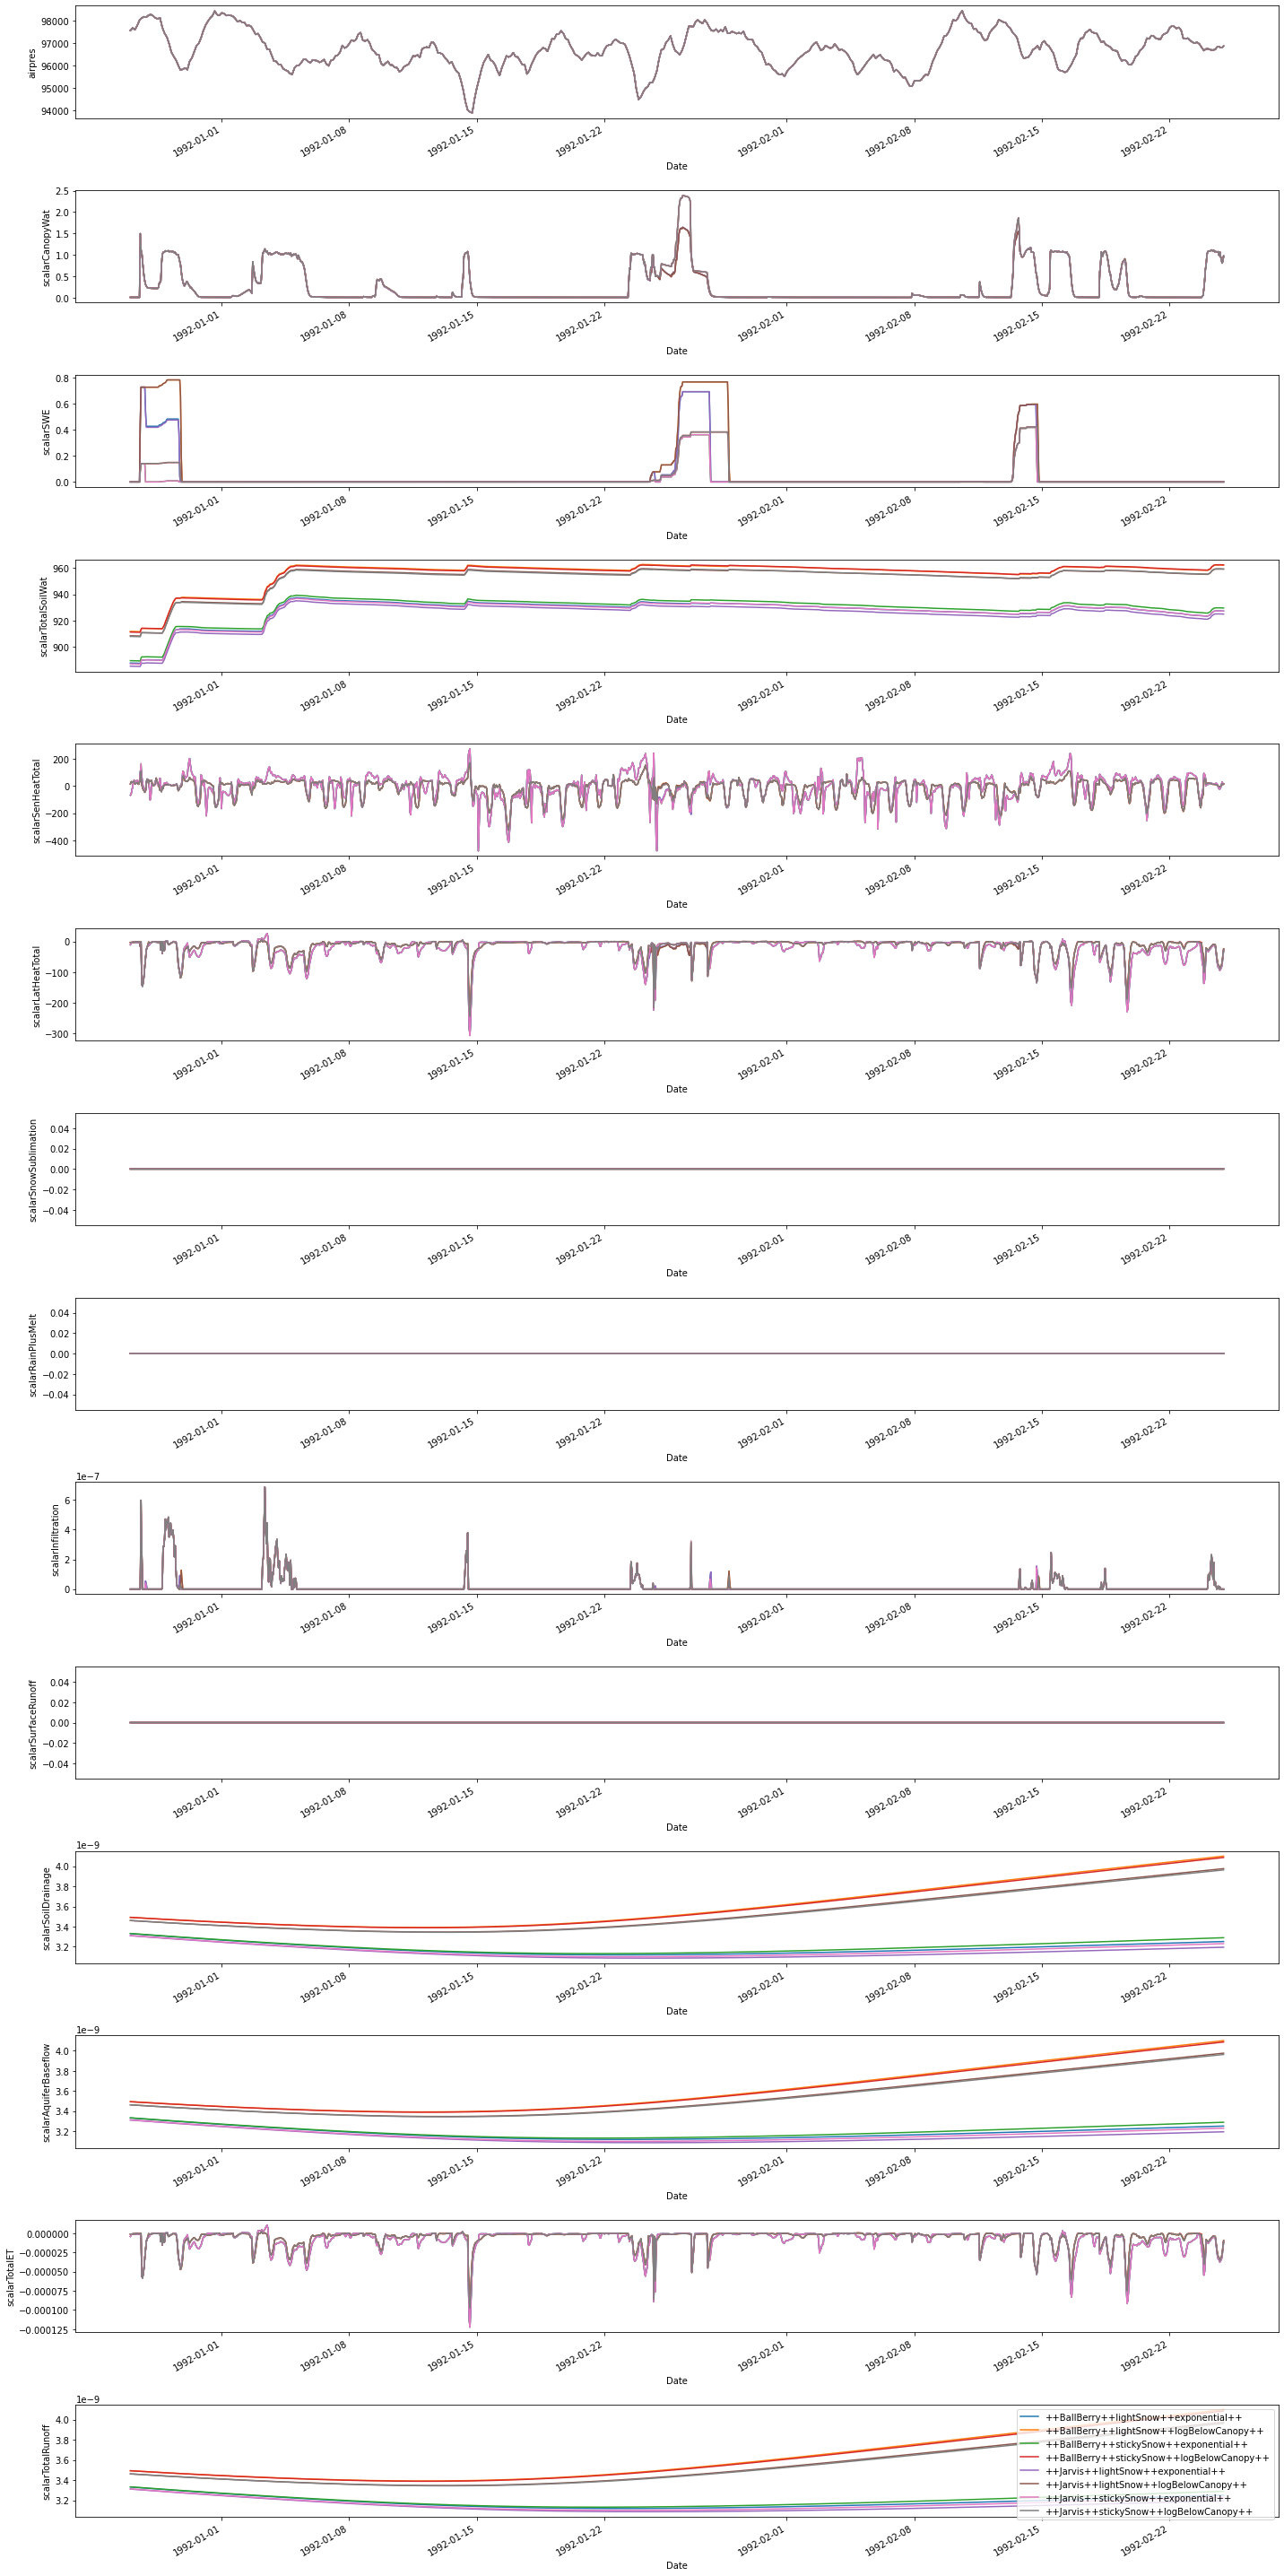

In [38]:
# Plot cummulative
if config_prob==1 and debug==0:
    fig, axes = plt.subplots(nrows=14, ncols=1, figsize=(20, 40))
    axes = axes.flatten()
    axes[0].set_title('Cumulative')

    variables = list(all_merged.variables.keys())[7:22]

    #start =  24*3*30 #summer
    start =  24*9*30 #winter
    stop = start + 2*30*24 
    truth_plt = all_merged.isel(hru=0, time=slice(start, stop))

    for idx, var in enumerate(variables[0:14]):
        for i, dec in enumerate(all_name):    
            truth_plt[var].isel(decision=i).plot(ax=axes[idx],label=dec)
        axes[idx].set_title('') 
        axes[idx].set_ylabel(var)
        axes[idx].set_xlabel('Date')
    plt.tight_layout()
    plt.legend()

In [39]:
#delete things to save memory as before
if config_prob==1 and debug==0:
    del param_ens
    del all_ds 
    del all_merged

<br>
Now run the other forcing sets as a loop. This takes about 7 X 0.8 minoots to run with 1 HRU.

In [40]:
%%time
# Each forcing constant, with 8 configurations.
if config_prob==1 and debug==0:
    constant_vars= ['airpres','airtemp','LWRadAtm','pptrate','spechum','SWRadAtm','windspd']
    for v in constant_vars:
        ! rm -rf {ps_working}
        file_manager = settings_folder+'/file_manager_constant_' + v +'.txt'
        s = ps.Simulation(executable, file_manager)
        s.manager['simStartTime'] = str(the_start)
        s.manager['simEndTime'] = str(the_end) 
        s.manager.write()           
        param_ens = ps.Ensemble(executable, config, file_manager, num_workers=NCORES)   
        param_ens.run('local')
        all_status = [(n, s.status) for n, s in param_ens.simulations.items()] #if want to look at status if has errors
        all_ds = [s.output.load() for n, s in param_ens.simulations.items()] #load it into memory so faster  
        all_name = [n for n, s in param_ens.simulations.items()]
        all_merged = xr.concat(all_ds, pd.Index(all_name, name="decision"))
        all_merged.to_netcdf(top_folder+'/output/merged_day/NLDASconstant_' + v +'_configs.nc')
        del param_ens
        del all_ds 
        del all_merged
        gc.collect()
        print(v)

airpres
airtemp
LWRadAtm
pptrate
spechum
SWRadAtm
windspd
CPU times: user 54.3 s, sys: 9.15 s, total: 1min 3s
Wall time: 5min 3s


<br>

If you have errors, debug mode will run a short time-period in non-ensemble (i.e. standard) pysumma mode. Set  `debug = 1` in the complexity choices. This will provide more detailed error messages.

In [41]:
if config_prob==1 and debug==1:
    for key0 in set(config):
        s = ps.Simulation(executable, file_manager)
        s.manager['simStartTime'] = str(the_start)
        s.manager['simEndTime'] = str(the_end_debug)
        for key1 in set(config[key0]):
            for key in set(config[key0].get(key1)):
                s.decisions[key].values = config[key0].get(key1).get(key)
        s.run('local', run_suffix='_default')
        assert s.status == 'Success'
        print(key0, s.status) #key0 is the configuration

<br>

# Run the Full Problem

This code will give the full problem, exploring the parameter space and the configurations together.
The next notebook in the series runs the most complete figures using this full problem, but parts of the figures can be drawn with the simpler problems. 
First, we combine the decision sets. 

In [42]:
# make ensembles with parameter space (numl parameter sets plus 1 for default), should make 88
if lhs_config_prob==1:
    config_latin = {}
    for key_config in config.keys():
        c = config[key_config]
        for key_latin in latin.keys():
            l = latin[key_latin]
            config_latin[key_config+key_latin] = {**c,**l}
    print(len(config_latin))

<br>
Now we run the truth problem. This takes about 7.4 minoots to run with 1 HRU.

In [43]:
%%time
# truth, parameter space with 8 configurations
if lhs_config_prob==1 and debug==0:
    param_ens = ps.Ensemble(executable, config_latin, file_manager, num_workers=NCORES)   
    param_ens.run('local')
    all_status = [(n, s.status) for n, s in param_ens.simulations.items()] #if want to look at status if has errors
    all_ds = [s.output.load() for n, s in param_ens.simulations.items()] #load it into memory so faster  
    all_name = [n for n, s in param_ens.simulations.items()]
    all_merged = xr.concat(all_ds, pd.Index(all_name, name="decision"))
    all_merged.to_netcdf(top_folder+'/output/merged_day/NLDAStruth_configs_latin.nc')

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 10.5 µs


In [44]:
# check that all were a success
if lhs_config_prob==1 and debug==0:
    print(all_status)

<br>
Again, we plot the cumulatative output for one HRU (the first one) for 2 winter months, to see how differences are compounding.

In [45]:
# Plot cummulative
if lhs_config_prob==1 and debug==0:
    fig, axes = plt.subplots(nrows=14, ncols=1, figsize=(20, 40))
    axes = axes.flatten()
    axes[0].set_title('Cumulative')

    variables = list(all_merged.variables.keys())[7:22]

    #start =  24*3*30 #summer
    start =  24*9*30 #winter
    stop = start + 2*30*24 
    truth_plt = all_merged.isel(hru=0, time=slice(start, stop))

    for idx, var in enumerate(variables[0:14]):
        for i, dec in enumerate(all_name):    
            truth_plt[var].isel(decision=i).plot(ax=axes[idx],label=dec)
        axes[idx].set_title('') 
        axes[idx].set_ylabel(var)
        axes[idx].set_xlabel('Date')
    plt.tight_layout()
    plt.legend()

In [46]:
#delete things to save memory as before
if lhs_config_prob==1 and debug==0:
    del param_ens
    del all_ds 
    del all_merged

<br>
Here, we run all the forcings. This takes about 7 X 7.4 minoots to run with 1 HRU.

In [47]:
%%time
# Each forcing constant, parameter space with 8 configurations.
if lhs_config_prob==1 and debug==0:
    constant_vars= ['airpres','airtemp','LWRadAtm','pptrate','spechum','SWRadAtm','windspd']
    for v in constant_vars:
        ! rm -rf {ps_working}
        file_manager = settings_folder+'/file_manager_constant_' + v +'.txt'
        s = ps.Simulation(executable, file_manager)
        s.manager['simStartTime'] = str(the_start)
        s.manager['simEndTime'] = str(the_end)  
        s.manager.write()       
        param_ens = ps.Ensemble(executable, config_latin, file_manager, num_workers=NCORES)   
        param_ens.run('local')
        all_status = [(n, s.status) for n, s in param_ens.simulations.items()] #if want to look at status if has errors
        all_ds = [s.output.load() for n, s in param_ens.simulations.items()] #load it into memory so faster  
        all_name = [n for n, s in param_ens.simulations.items()]
        all_merged = xr.concat(all_ds, pd.Index(all_name, name="decision"))
        all_merged.to_netcdf(top_folder+'/output/merged_day/NLDASconstant_' + v +'_configs_latin.nc')
        del param_ens
        del all_ds 
        del all_merged
        gc.collect()
        print(v)

CPU times: user 7 µs, sys: 1e+03 ns, total: 8 µs
Wall time: 15 µs


<br>

If you have errors, debug mode will run a short time-period in non-ensemble (i.e. standard) pysumma mode. Set `debug = 1` in the complexity choices. This will provide more detailed error messages.

In [48]:
if lhs_config_prob==1 and debug==1:
    for key0 in set(config):
        s = ps.Simulation(executable, file_manager)
        s.manager['simStartTime'] = str(the_start)
        s.manager['simEndTime'] = str(the_end_debug)
        for key1 in set(config[key0]):
            for key in set(config[key0].get(key1)):
                s.decisions[key].values = config[key0].get(key1).get(key)
        s.run('local', run_suffix='_default')
        assert s.status == 'Success'
        print(0, key0, s.status) #0 is default parameter set, key0 is the configuration

    for j in range(0,numl):
        for key0 in set(config):
            s = ps.Simulation(executable, file_manager)
            s.manager['simStartTime'] = str(the_start)
            s.manager['simEndTime'] = str(the_end_debug)
            for key in set(samples):
                s.trial_params[key].values =  samples.get(key)[np.arange(j, len(the_hru)*numl, numl)]
            for key1 in set(config[key0]):
                for key in set(config[key0].get(key1)):
                    s.decisions[key].values = config[key0].get(key1).get(key)
            s.run('local', run_suffix='_default')
            assert s.status == 'Success'
            print(j+1, key0, s.status) #j+1 is the number of the LHS parameter set, key0 is the configuration